# A Sketch of K-Fold CV Variance
### Julien Brenneck, June 2018

In [1]:
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn
seaborn.set_color_codes()

cm = mpl.cm.RdBu
h = 0.02

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)
X, y = make_moons(noise=0.3, random_state=0)

### The Data; The Model

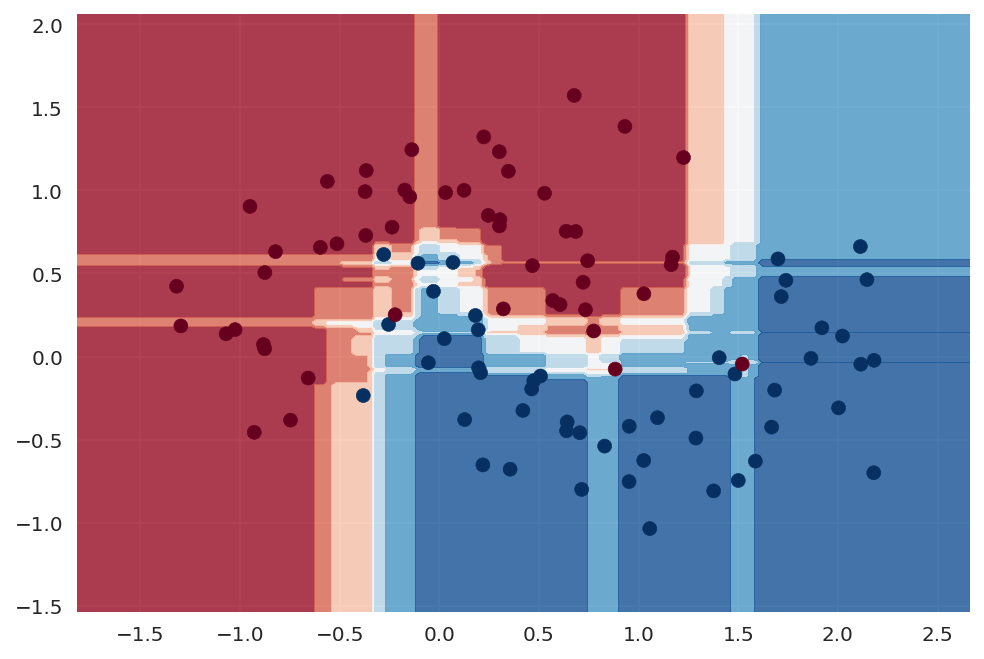

In [4]:
tree = RandomForestClassifier()
tree.fit(X, y)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = tree.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X[:,0], X[:,1], c=y, cmap=cm)

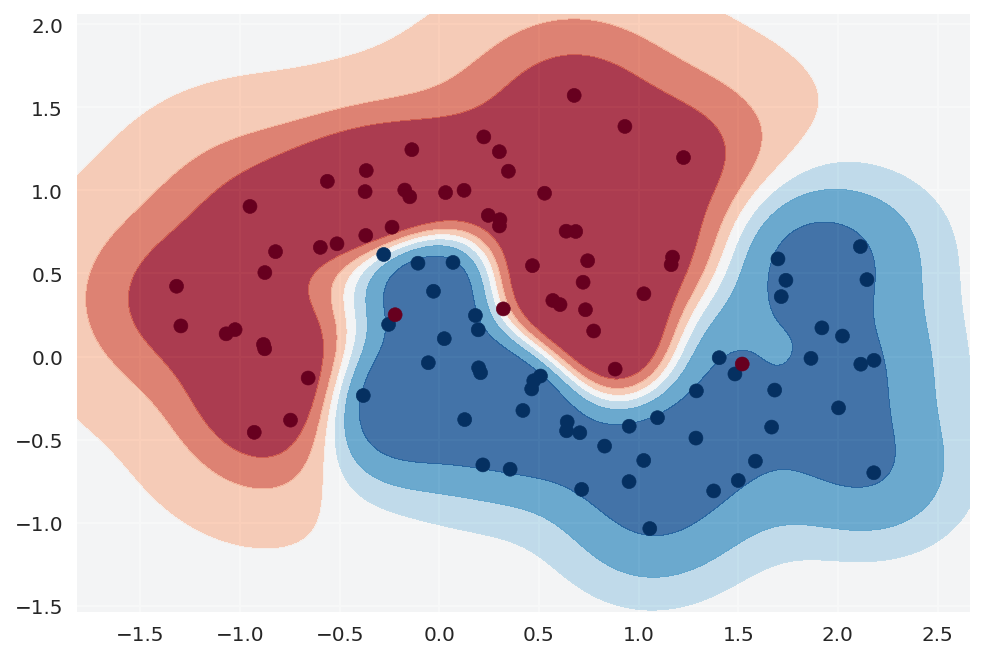

In [5]:
rbf = SVC(probability=True, gamma=5, C=5, kernel='rbf')
rbf.fit(X, y)
h = 0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = rbf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X[:,0], X[:,1], c=y, cmap=cm)

In [6]:
from sklearn.model_selection import cross_val_score, KFold

In [26]:
X, y = make_moons(noise=0.3, n_samples=100)

# model = SVC(kernel='linear', C=10, gamma=10)
model = KNeighborsClassifier(1)

scores = np.zeros(99)
std = np.zeros(99)
for i in range(99):
#     z = cross_val_score(SVC(kernel='linear', C=10, gamma=10), X, y, cv=KFold(i+2), n_jobs=-1)
    z = cross_val_score(KNeighborsClassifier(1), X, y, cv=KFold(i+2), n_jobs=-1)
    scores[i] = np.mean(z)
    std[i] = np.std(z)

### A Naive Approximation
Taking the sample standard deviation of the score from each fold of k-fold CV and ploting against the choice of k.

This shows the result we want to see, variance increasing as k increases towards LOOCV. But there is no reason to expect that this is a valid estimator of what we are actually interested in, the true model variance. In fact we know that this is necessarily a biased estimator, and that the bias can be the same order of magnitude as the total variance (Bengio & Grandvalet 2004). It shows a trend we hoped to observe, but is not a useful measure in practice. 

Interestingly we see no change in bias as k increases, likely due to the simplicity of the model and data. 

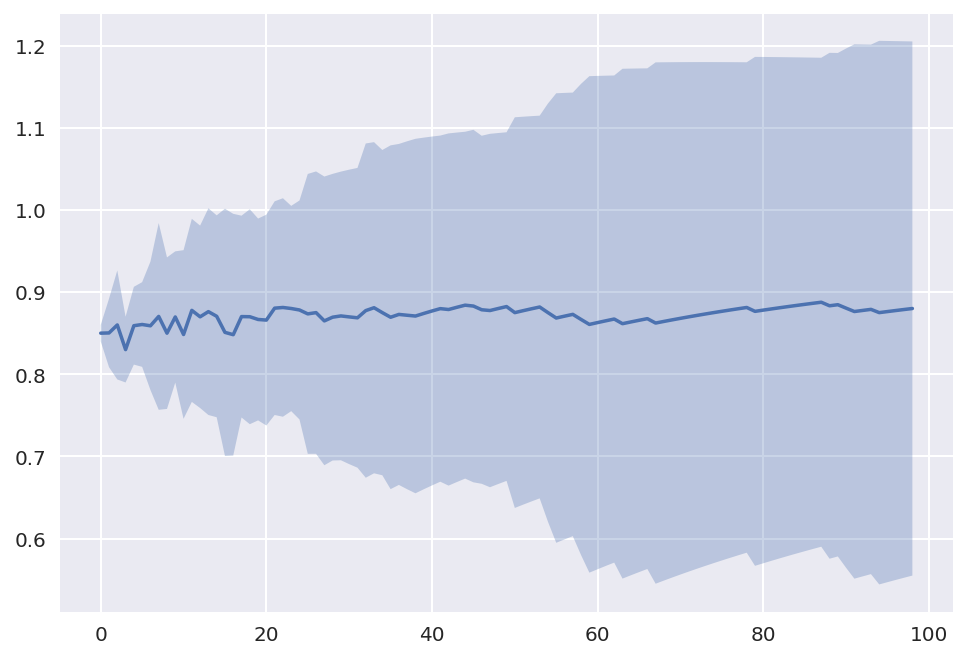

In [27]:
plt.plot(scores)
plt.fill_between(np.arange(99), scores-std, scores+std, alpha=0.3)

In [20]:
N = 30
scores_all = np.zeros((10, N-1))
std_all = np.zeros((10, N-1))
for j in range(10):
    X, y = make_moons(noise=0.3, n_samples=N)
    for i in range(N-1):
        z = cross_val_score(KNeighborsClassifier(5), X, y, cv=KFold(i+2), n_jobs=8)
        scores_all[j, i] = np.mean(z)
        std_all[j, i] = np.std(z)

When CV variance is taken as the variance of scores over models trained on defferent datasets from the same underlying distribution, we no longer see the trend. This could be due to the choice of model, but it still gives more reason to question the results from variance of fold scores.

Model/dataset might be _stable_ under k-fold (Kohavi 1995)?

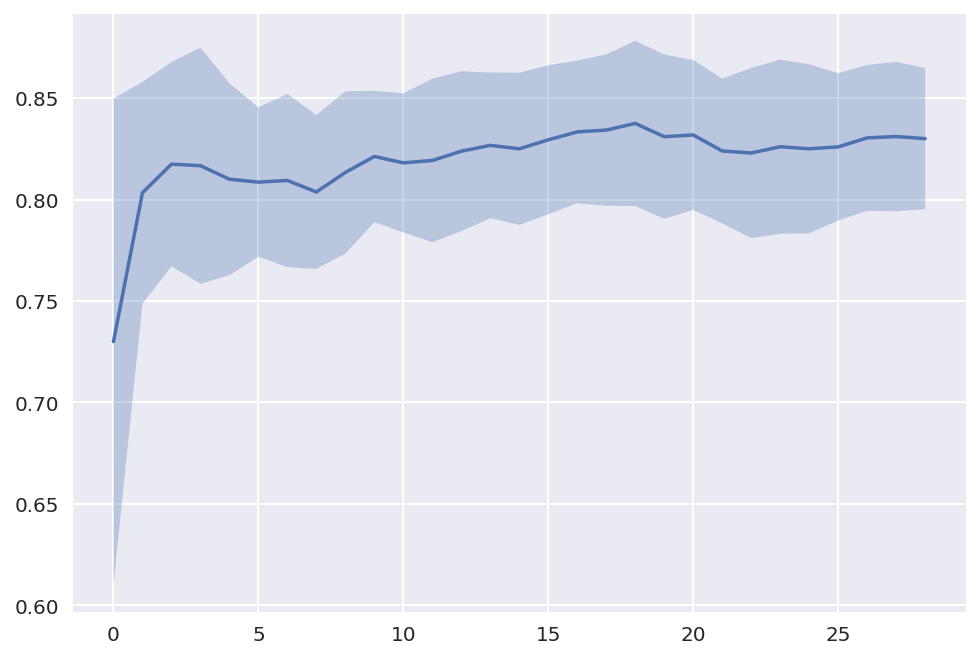

In [21]:
s1 = np.mean(scores_all, axis=0)
plt.plot(s1)
s2 = np.std(scores_all, axis=0)
plt.fill_between(np.arange(N-1), s1-s2, s1+s2, alpha=0.3)